In [9]:
""" Script to produce Figs. 6 and S10-14 """
from ofc import System, parmap
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

In [2]:
# Okabe & Ito's colorblind friendly palette
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]
plt.rc('axes', prop_cycle=plt.cycler('color', colors))
plt.rc('font', size=18)
plt.rc('legend', **{'fontsize': 12})

T = 111
v = 1e-4
q = 200
force = 2e-3

delay = 5
dt = 1  # 10 msec
A0 = np.array([[1, 0, dt, 0, 0, 0],
               [0, 1, 0, dt, 0, 0],
               [0, 0, 1, 0, dt, 0],
               [0, 0, 0, 1, 0, dt],
               [0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 1]])
B = np.array([[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [dt, 0],
              [0, dt]])
m = len(A0)
C = np.eye(m)
n = len(C)
V = v * np.diag([1, 1, .1, .1, .01, .01])
W = V
Q = 1e-5 * np.diag([1, 1, q, q, 0, 0])
R = np.eye(2)

nullfield = System(A0, B, C, V, W, Q, R, T)
A = A0.astype(float)
A[2:4, 2:4] += force*np.array([[-10.1, -11.2],
                               [-11.2, 11.1]])
forcefield = System(A, B, C, V, W, Q, R, T)

In [7]:
S = nullfield.P[-1].copy()
for _ in range(delay-1):
    S = A0.dot(S).dot(A0.T) + V
S = C.dot(S).dot(C.T) + W
invS = np.linalg.inv(S)
det = np.linalg.slogdet(2*np.pi*S)[1]/2

def objective(ABCLhat, delay=delay):
    """Run 10000 episodes using estimates for matrices A, B, C, and L.

    Parameters
    ----------
    ABCLhat : tuple of ndarrays
        The estimates for matrices A, B, C, and L.
    delay : int
        delay >= 1

    Returns
    -------
    -loglikelihood
    """
    samples = 1000
    splits = 10
    Chat = ABCLhat[2]

    def foo(see, samples=samples // splits, ABCLhat=ABCLhat, delay=delay):
        ll = np.zeros(samples)
        for i, seed in enumerate(range(see, see + samples)):
            alpha = seed * np.pi / 4
            x0 = 10 * np.array([np.cos(alpha), np.sin(alpha)] + [0] * (m - 2))
            U, X, Y, _, _, Xhat, _ = nullfield.LQG(
                seed, ABCLhat=ABCLhat, delay=delay, actor="-K[t].dot(Xhat[t])", x0=x0)
            es = Y-Xhat.dot(Chat.T)
            ll[i] = np.trace(es.T.dot(es).dot(invS))/T/2 + det
        return ll
    return np.mean(parmap(foo, range(0, samples, samples // splits)))

mask = np.nonzero(nullfield.L[-1])

def foo(a, delay=1):
    b = np.zeros((m, n))
    b[mask] = a
    return objective((A0, B, C, b), delay=delay)

In [10]:
res = minimize(lambda a: foo(a, delay=delay), A0.dot(nullfield.L[-1])[mask] / delay)
L = np.zeros((m, n))
L[mask] = res.x
np.save('results/L_nullfield', L)

AttributeError: Can't pickle local object 'parmap.<locals>.fun'

NameError: name 'L' is not defined

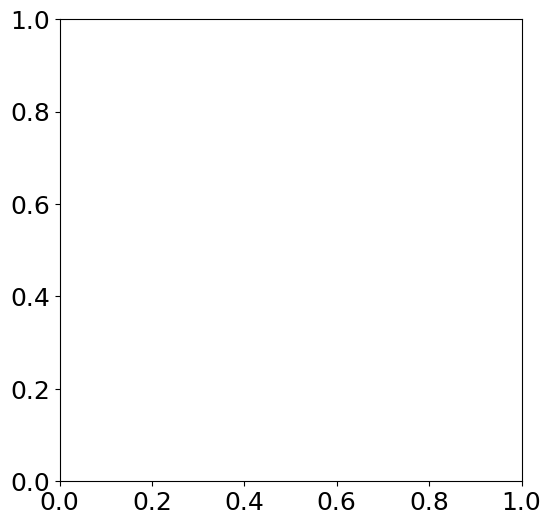

In [11]:
multiplicative_noise = 0
#for multiplicative_noise in (0,1):
# Fig 6
Tplot = 51
plt.figure(figsize=(6.2, 6))
plt.gca().set_aspect(1)
for i in range(8):
    alpha = i*np.pi/4
    x0 = 10 * np.array([np.cos(alpha), np.sin(alpha)] + [0]*(m-2))  # [cm]
    plt.gca().set_aspect(1)
    for seed in range(8*i, 8*i+5):
        U, X, Y, Xpre, Xpost, Xhat, _ = nullfield.LQG(
            seed, ABCLhat=(A0, B, C, L),
            actor="-np.array(" + str(nullfield.K[0].tolist()) + ").dot(Xhat[t])",
            delay=delay, x0=x0, multiplicative_noise=multiplicative_noise)
        plt.scatter(*np.transpose(X[:Tplot, :2]-np.array(x0[:2])), s=5, c='C%g' % i)
plt.yticks([-10, -5, 0, 5, 10])
plt.xlabel('Displacement [cm]')
plt.ylabel('Displacement [cm]', labelpad=-5)
plt.tight_layout(pad=.05)
#plt.savefig('fig/forcefield_fig6' + ('', '_multNoise')[multiplicative_noise] + '.pdf')

In [ ]:
# Fig 7
plt.figure(figsize=(5, 6))
plt.gca().set_aspect(1)
for i in range(8):
    alpha = i*np.pi/4
    x0 = 10 * np.array([np.cos(alpha), np.sin(alpha)] + [0]*(m-2))
    plt.gca().add_patch(plt.Circle(x0[:2], .8, fc='w', ec='k', zorder=-11))
    for seed in range(8*i, 8*i+3):
        U, X, Y, Xpre, Xpost, Xhat, _ = forcefield.LQG(
            seed, ABCLhat=(A0, B, C, L),
            actor="-np.array(" + str(nullfield.K[0].tolist()) + ").dot(Xhat[t])",
            delay=delay, x0=x0, T=(111, 121)[multiplicative_noise], asymptoticL=True,
            multiplicative_noise=multiplicative_noise)
        plt.scatter(*np.transpose(X[:, :2]-np.array(x0[:2])), s=5, c='C%g' % i)
plt.xlabel('Displacement [cm]')
plt.ylabel('Displacement [cm]', labelpad=-5)
plt.tight_layout(pad=.05)
plt.savefig('fig/forcefield_fig7' + ('', '_multNoise')[multiplicative_noise] + '.pdf')